# Modeling - Linear Regression with Elastic Net

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import ElasticNet
from itertools import product
import pickle
import json

In [2]:
df_train = pd.read_pickle(r"feature_engineering_train_dataset.pkl")
df_valid = pd.read_pickle(r"feature_engineering_validation_dataset.pkl")

## CO(GT)

In [3]:
feature_cols = 'COGT'
X_train = df_train.drop(columns = {"date_time",feature_cols})
y_train = df_train[feature_cols] 

X_valid = df_valid.drop(columns = {"date_time",feature_cols})
y_valid = df_valid[feature_cols] 

In [4]:
last_col_scale_index = 611+1
columns_to_scale = [a_col for a_col in X_train.iloc[:,:last_col_scale_index].columns]
scaler = StandardScaler()

# Fit and transform only selected columns
X_train_scaled = scaler.fit_transform(X_train[columns_to_scale])
X_train[columns_to_scale] = X_train_scaled

X_valid_scaled = scaler.transform(X_valid[columns_to_scale])
X_valid[columns_to_scale] = X_valid_scaled

# Save the means and standard deviations for coefficient adjustment
feature_means = scaler.mean_
feature_stds = scaler.scale_

with open("scaler_for_COGT.pkl", "wb") as f:
    pickle.dump(scaler, f)

column_order = list(X_train.columns)
with open("column_orderfor_COGT.json", "w") as f:
    json.dump(column_order, f)

In [5]:
display(X_train.head(3))
display(X_valid.head(3))

,PT08.S1CO,C6H6GT,NOxGT,PT08.S3NOx,NO2GT,PT08.S4NO2,PT08.S5O3,T,RH,AH,...,hour_20,hour_21,hour_22,hour_23,day_of_week_Monday,day_of_week_Tuesday,day_of_week_Wednesday,day_of_week_Thursday,day_of_week_Friday,day_of_week_Saturday
0,-0.051345,-0.633629,-0.338100,1.692903,0.096420,-0.894693,-0.462696,-2.054872,0.794870,-1.640633,...,0,0,0,0,0,0,0,0,1,0
1,-0.222804,-0.565075,-0.258855,1.662753,0.448479,-0.883444,-0.417915,-2.137872,0.867023,-1.678354,...,0,0,0,0,0,0,0,0,1,0
2,-0.489519,-0.880424,-0.626261,2.304517,-0.066069,-1.160913,-0.809753,-2.220872,0.993292,-1.687639,...,0,0,0,0,0,0,0,0,1,0


,PT08.S1CO,C6H6GT,NOxGT,PT08.S3NOx,NO2GT,PT08.S4NO2,PT08.S5O3,T,RH,AH,...,hour_20,hour_21,hour_22,hour_23,day_of_week_Monday,day_of_week_Tuesday,day_of_week_Wednesday,day_of_week_Thursday,day_of_week_Friday,day_of_week_Saturday
0,0.148691,-0.002930,0.648853,-0.865540,-0.851432,-0.103531,0.186635,-0.657701,1.865145,1.138819,...,0,0,0,0,0,1,0,0,0,0
1,-0.513333,-0.400544,0.418324,-0.469283,-1.013921,-0.530984,-0.149226,-0.685368,1.871157,1.072082,...,0,0,0,0,0,1,0,0,0,0
2,-0.980085,-0.784448,-0.157999,0.073417,-1.203491,-0.898443,-0.471093,-0.726868,1.774953,0.907271,...,0,0,0,0,0,1,0,0,0,0


In [6]:
print("Train shape:", X_train.shape)
print("Valid shape:", X_valid.shape)

Train shape: (5616, 641)
Valid shape: (1440, 641)


In [7]:
list_alpha = [0.01, 0.1, 1.0, 10]
list_l1_ratio = [0.1, 0.5, 0.9]
results = []

combinations = list(product(list_alpha, list_l1_ratio))
for alpha, l1_ratio in combinations:
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=88)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    mae = mean_absolute_error(y_valid, y_pred)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    results.append({
        'alpha': alpha,
        'l1_ratio': l1_ratio,
        'MAE': mae,
        'RMSE': rmse
    })
df_results = pd.DataFrame(results).sort_values('RMSE').reset_index(drop = True)
display(df_results)

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.202e+01, tolerance: 1.026e+00
  model = cd_fast.enet_coordinate_descent(


,alpha,l1_ratio,MAE,RMSE
0,0.01,0.9,0.303097,0.469704
1,0.01,0.5,0.308365,0.472478
2,0.01,0.1,0.310416,0.474519
3,0.10,0.1,0.341201,0.513930
4,0.10,0.5,0.433520,0.621814
5,0.10,0.9,0.453244,0.653901
6,1.00,0.1,0.536977,0.779300
7,1.00,0.5,0.768795,1.092741
8,1.00,0.9,1.199079,1.679402
9,10.00,0.1,1.403756,1.956276


In [8]:
best_row = df_results.loc[df_results['RMSE'].idxmin()]
best_alpha = best_row['alpha']
best_l1_ratio = best_row['l1_ratio']

print(f"Best alpha: {best_alpha}, Best l1_ratio: {best_l1_ratio}")

Best alpha: 0.01, Best l1_ratio: 0.9


In [9]:
model = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, random_state=88)
model.fit(X_train, y_train)

with open('elasticnet_model_for_COGT.pkl', 'wb') as f:
    pickle.dump(model, f)

# Get standardized coefficients
standardized_coefficients = model.coef_
intercept = model.intercept_

# Assuming standardized_coefficients includes all features
scaled_coefs = standardized_coefficients[:last_col_scale_index]
unscaled_coefs = standardized_coefficients[last_col_scale_index:]

# Adjust only the scaled coefficients
original_scaled_coefs = scaled_coefs / feature_stds

# Combine back the full coefficient vector
original_coefficients = np.concatenate([original_scaled_coefs, unscaled_coefs])

# Adjust intercept
original_intercept = intercept - np.sum(original_scaled_coefs * feature_means)

In [10]:
train_pred = model.predict(X_train)
mae_train = mean_absolute_error(y_train, train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, train_pred))

print("Train MAE    :", round(mae_train,4))
print("Train RMSE   :", round(rmse_train,4))

Train MAE    : 0.2043
Train RMSE   : 0.3072


In [11]:
y_pred = model.predict(X_valid)
mae_validation = mean_absolute_error(y_valid, y_pred)
rmse_validation = np.sqrt(mean_squared_error(y_valid, y_pred))

print("Validation MAE   :", round(mae_validation,4))
print("Validation RMSE  :", round(rmse_validation,4))

Validation MAE   : 0.3031
Validation RMSE  : 0.4697


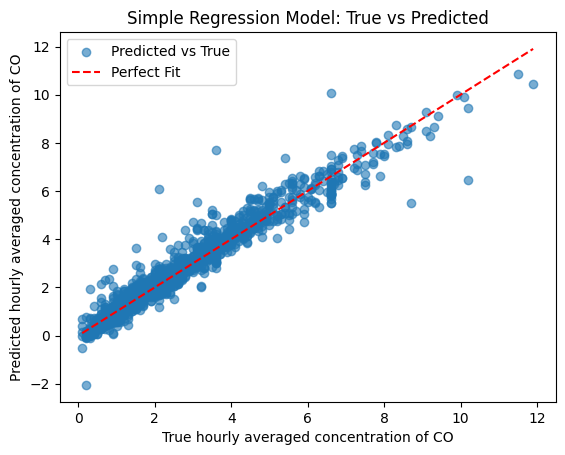

In [12]:
# Scatter plot: True vs Predicted
plt.scatter(y_valid, y_pred, alpha=0.6, label="Predicted vs True")
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--', label="Perfect Fit")
plt.title("Simple Regression Model: True vs Predicted")
plt.xlabel("True hourly averaged concentration of CO")
plt.ylabel("Predicted hourly averaged concentration of CO")
plt.legend()
plt.show()

## C6H6(GT)

In [13]:
feature_cols = 'C6H6GT'
X_train = df_train.drop(columns = {"date_time",feature_cols})
y_train = df_train[feature_cols] 

X_valid = df_valid.drop(columns = {"date_time",feature_cols})
y_valid = df_valid[feature_cols] 

In [14]:
last_col_scale_index = 611+1
columns_to_scale = [a_col for a_col in X_train.iloc[:,:last_col_scale_index].columns]
scaler = StandardScaler()

# Fit and transform only selected columns
X_train_scaled = scaler.fit_transform(X_train[columns_to_scale])
X_train[columns_to_scale] = X_train_scaled

X_valid_scaled = scaler.transform(X_valid[columns_to_scale])
X_valid[columns_to_scale] = X_valid_scaled

# Save the means and standard deviations for coefficient adjustment
feature_means = scaler.mean_
feature_stds = scaler.scale_

with open("scaler_for_C6H6GT.pkl", "wb") as f:
    pickle.dump(scaler, f)

column_order = list(X_train.columns)
with open("column_orderfor_C6H6GT.json", "w") as f:
    json.dump(column_order, f)

In [15]:
display(X_train.head(3))
display(X_valid.head(3))

,COGT,PT08.S1CO,NOxGT,PT08.S3NOx,NO2GT,PT08.S4NO2,PT08.S5O3,T,RH,AH,...,hour_20,hour_21,hour_22,hour_23,day_of_week_Monday,day_of_week_Tuesday,day_of_week_Wednesday,day_of_week_Thursday,day_of_week_Friday,day_of_week_Saturday
0,-0.198695,-0.051345,-0.338100,1.692903,0.096420,-0.894693,-0.462696,-2.054872,0.794870,-1.640633,...,0,0,0,0,0,0,0,0,1,0
1,-0.050760,-0.222804,-0.258855,1.662753,0.448479,-0.883444,-0.417915,-2.137872,0.867023,-1.678354,...,0,0,0,0,0,0,0,0,1,0
2,-0.420596,-0.489519,-0.626261,2.304517,-0.066069,-1.160913,-0.809753,-2.220872,0.993292,-1.687639,...,0,0,0,0,0,0,0,0,1,0


,COGT,PT08.S1CO,NOxGT,PT08.S3NOx,NO2GT,PT08.S4NO2,PT08.S5O3,T,RH,AH,...,hour_20,hour_21,hour_22,hour_23,day_of_week_Monday,day_of_week_Tuesday,day_of_week_Wednesday,day_of_week_Thursday,day_of_week_Friday,day_of_week_Saturday
0,0.245109,0.148691,0.648853,-0.865540,-0.851432,-0.103531,0.186635,-0.657701,1.865145,1.138819,...,0,0,0,0,0,1,0,0,0,0
1,-0.272662,-0.513333,0.418324,-0.469283,-1.013921,-0.530984,-0.149226,-0.685368,1.871157,1.072082,...,0,0,0,0,0,1,0,0,0,0
2,-0.642498,-0.980085,-0.157999,0.073417,-1.203491,-0.898443,-0.471093,-0.726868,1.774953,0.907271,...,0,0,0,0,0,1,0,0,0,0


In [16]:
print("Train shape:", X_train.shape)
print("Valid shape:", X_valid.shape)

Train shape: (5616, 641)
Valid shape: (1440, 641)


In [17]:
list_alpha = [0.01, 0.1, 1.0, 10]
list_l1_ratio = [0.1, 0.5, 0.9]
results = []

combinations = list(product(list_alpha, list_l1_ratio))
for alpha, l1_ratio in combinations:
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=88)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    mae = mean_absolute_error(y_valid, y_pred)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    results.append({
        'alpha': alpha,
        'l1_ratio': l1_ratio,
        'MAE': mae,
        'RMSE': rmse
    })
df_results = pd.DataFrame(results).sort_values('RMSE').reset_index(drop = True)
display(df_results)

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.354e+03, tolerance: 2.987e+01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.308e+02, tolerance: 2.987e+01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-p

,alpha,l1_ratio,MAE,RMSE
0,0.01,0.9,0.712947,1.449708
1,0.01,0.5,0.737251,1.452328
2,0.01,0.1,0.758100,1.452867
3,0.10,0.1,1.105066,1.818581
4,0.10,0.5,1.140396,1.847956
5,0.10,0.9,1.262434,1.905482
6,1.00,0.1,1.835425,2.852906
7,1.00,0.5,1.967395,3.050744
8,1.00,0.9,2.282588,3.379936
9,10.00,0.1,4.176048,5.686989


In [18]:
best_row = df_results.loc[df_results['RMSE'].idxmin()]
best_alpha = best_row['alpha']
best_l1_ratio = best_row['l1_ratio']

print(f"Best alpha: {best_alpha}, Best l1_ratio: {best_l1_ratio}")

Best alpha: 0.01, Best l1_ratio: 0.9


In [19]:
model = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, random_state=88)
model.fit(X_train, y_train)

with open('elasticnet_model_for_C6H6GT.pkl', 'wb') as f:
    pickle.dump(model, f)
    
# Get standardized coefficients
standardized_coefficients = model.coef_
intercept = model.intercept_

# Assuming standardized_coefficients includes all features
scaled_coefs = standardized_coefficients[:last_col_scale_index]
unscaled_coefs = standardized_coefficients[last_col_scale_index:]

# Adjust only the scaled coefficients
original_scaled_coefs = scaled_coefs / feature_stds

# Combine back the full coefficient vector
original_coefficients = np.concatenate([original_scaled_coefs, unscaled_coefs])

# Adjust intercept
original_intercept = intercept - np.sum(original_scaled_coefs * feature_means)

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.972e+02, tolerance: 2.987e+01
  model = cd_fast.enet_coordinate_descent(


In [20]:
train_pred = model.predict(X_train)
mae_train = mean_absolute_error(y_train, train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, train_pred))

print("Train MAE    :", round(mae_train,4))
print("Train RMSE   :", round(rmse_train,4))


Train MAE    : 0.5338
Train RMSE   : 0.9201


In [21]:
y_pred = model.predict(X_valid)
mae_validation = mean_absolute_error(y_valid, y_pred)
rmse_validation = np.sqrt(mean_squared_error(y_valid, y_pred))

print("Validation MAE   :", round(mae_validation,4))
print("Validation RMSE  :", round(rmse_validation,4))

Validation MAE   : 0.7129
Validation RMSE  : 1.4497


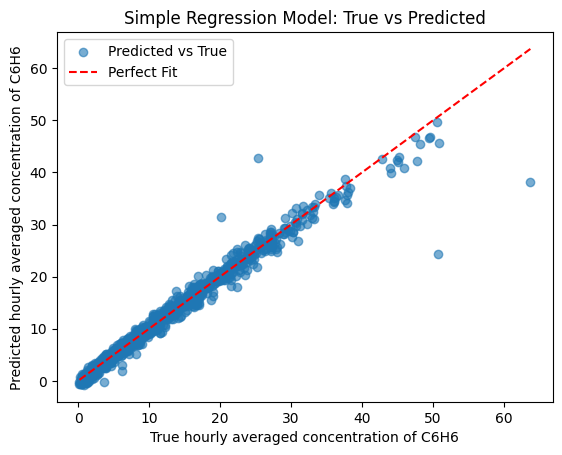

In [22]:
# Scatter plot: True vs Predicted
plt.scatter(y_valid, y_pred, alpha=0.6, label="Predicted vs True")
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--', label="Perfect Fit")
plt.title("Simple Regression Model: True vs Predicted")
plt.xlabel("True hourly averaged concentration of C6H6")
plt.ylabel("Predicted hourly averaged concentration of C6H6")
plt.legend()
plt.show()

## NOx(GT)

In [23]:
feature_cols = 'NOxGT'
X_train = df_train.drop(columns = {"date_time",feature_cols})
y_train = df_train[feature_cols] 

X_valid = df_valid.drop(columns = {"date_time",feature_cols})
y_valid = df_valid[feature_cols] 

In [24]:
last_col_scale_index = 611+1
columns_to_scale = [a_col for a_col in X_train.iloc[:,:last_col_scale_index].columns]
scaler = StandardScaler()

# Fit and transform only selected columns
X_train_scaled = scaler.fit_transform(X_train[columns_to_scale])
X_train[columns_to_scale] = X_train_scaled

X_valid_scaled = scaler.transform(X_valid[columns_to_scale])
X_valid[columns_to_scale] = X_valid_scaled

# Save the means and standard deviations for coefficient adjustment
feature_means = scaler.mean_
feature_stds = scaler.scale_

with open("scaler_for_NOxGT.pkl", "wb") as f:
    pickle.dump(scaler, f)

column_order = list(X_train.columns)
with open("column_orderfor_NOxGT.json", "w") as f:
    json.dump(column_order, f)

In [25]:
display(X_train.head(3))
display(X_valid.head(3))

,COGT,PT08.S1CO,C6H6GT,PT08.S3NOx,NO2GT,PT08.S4NO2,PT08.S5O3,T,RH,AH,...,hour_20,hour_21,hour_22,hour_23,day_of_week_Monday,day_of_week_Tuesday,day_of_week_Wednesday,day_of_week_Thursday,day_of_week_Friday,day_of_week_Saturday
0,-0.198695,-0.051345,-0.633629,1.692903,0.096420,-0.894693,-0.462696,-2.054872,0.794870,-1.640633,...,0,0,0,0,0,0,0,0,1,0
1,-0.050760,-0.222804,-0.565075,1.662753,0.448479,-0.883444,-0.417915,-2.137872,0.867023,-1.678354,...,0,0,0,0,0,0,0,0,1,0
2,-0.420596,-0.489519,-0.880424,2.304517,-0.066069,-1.160913,-0.809753,-2.220872,0.993292,-1.687639,...,0,0,0,0,0,0,0,0,1,0


,COGT,PT08.S1CO,C6H6GT,PT08.S3NOx,NO2GT,PT08.S4NO2,PT08.S5O3,T,RH,AH,...,hour_20,hour_21,hour_22,hour_23,day_of_week_Monday,day_of_week_Tuesday,day_of_week_Wednesday,day_of_week_Thursday,day_of_week_Friday,day_of_week_Saturday
0,0.245109,0.148691,-0.002930,-0.865540,-0.851432,-0.103531,0.186635,-0.657701,1.865145,1.138819,...,0,0,0,0,0,1,0,0,0,0
1,-0.272662,-0.513333,-0.400544,-0.469283,-1.013921,-0.530984,-0.149226,-0.685368,1.871157,1.072082,...,0,0,0,0,0,1,0,0,0,0
2,-0.642498,-0.980085,-0.784448,0.073417,-1.203491,-0.898443,-0.471093,-0.726868,1.774953,0.907271,...,0,0,0,0,0,1,0,0,0,0


In [26]:
print("Train shape:", X_train.shape)
print("Valid shape:", X_valid.shape)

Train shape: (5616, 641)
Valid shape: (1440, 641)


In [27]:
list_alpha = [0.01, 0.1, 1.0, 10]
list_l1_ratio = [0.1, 0.5, 0.9]
results = []

combinations = list(product(list_alpha, list_l1_ratio))
for alpha, l1_ratio in combinations:
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=88)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    mae = mean_absolute_error(y_valid, y_pred)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    results.append({
        'alpha': alpha,
        'l1_ratio': l1_ratio,
        'MAE': mae,
        'RMSE': rmse
    })
df_results = pd.DataFrame(results).sort_values('RMSE').reset_index(drop = True)
display(df_results)

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.970e+06, tolerance: 1.082e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.380e+06, tolerance: 1.082e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-p

,alpha,l1_ratio,MAE,RMSE
0,0.01,0.9,51.136288,74.920215
1,0.01,0.5,52.609014,76.583667
2,0.01,0.1,53.928689,78.230262
3,0.10,0.9,54.406038,79.293918
4,0.10,0.5,62.492676,89.519459
5,0.10,0.1,67.579909,95.906127
6,1.00,0.9,71.220462,101.127189
7,1.00,0.5,88.745627,122.904249
8,1.00,0.1,97.072026,133.012614
9,10.00,0.9,104.844642,149.231317


In [28]:
best_row = df_results.loc[df_results['RMSE'].idxmin()]
best_alpha = best_row['alpha']
best_l1_ratio = best_row['l1_ratio']

print(f"Best alpha: {best_alpha}, Best l1_ratio: {best_l1_ratio}")

Best alpha: 0.01, Best l1_ratio: 0.9


In [29]:
model = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, random_state=88)
model.fit(X_train, y_train)

with open('elasticnet_model_for_NOxGT.pkl', 'wb') as f:
    pickle.dump(model, f)
    
# Get standardized coefficients
standardized_coefficients = model.coef_
intercept = model.intercept_

# Assuming standardized_coefficients includes all features
scaled_coefs = standardized_coefficients[:last_col_scale_index]
unscaled_coefs = standardized_coefficients[last_col_scale_index:]

# Adjust only the scaled coefficients
original_scaled_coefs = scaled_coefs / feature_stds

# Combine back the full coefficient vector
original_coefficients = np.concatenate([original_scaled_coefs, unscaled_coefs])

# Adjust intercept
original_intercept = intercept - np.sum(original_scaled_coefs * feature_means)

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.358e+05, tolerance: 1.082e+04
  model = cd_fast.enet_coordinate_descent(


In [30]:
train_pred = model.predict(X_train)
mae_train = mean_absolute_error(y_train, train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, train_pred))

print("Train MAE    :", round(mae_train,4))
print("Train RMSE   :", round(rmse_train,4))


Train MAE    : 14.8772
Train RMSE   : 24.0313


In [31]:
y_pred = model.predict(X_valid)
mae_validation = mean_absolute_error(y_valid, y_pred)
rmse_validation = np.sqrt(mean_squared_error(y_valid, y_pred))

print("Validation MAE   :", round(mae_validation,4))
print("Validation RMSE  :", round(rmse_validation,4))

Validation MAE   : 51.1363
Validation RMSE  : 74.9202


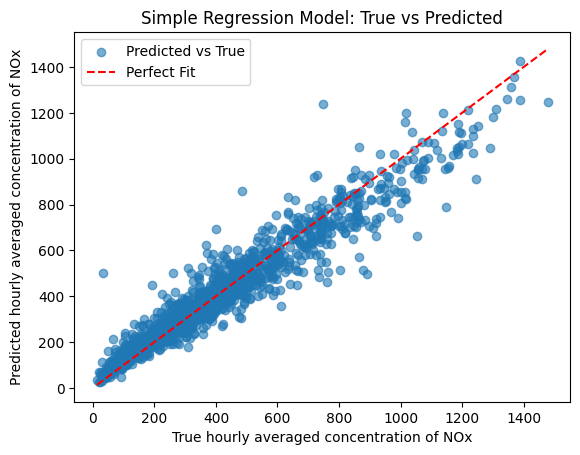

In [32]:
# Scatter plot: True vs Predicted
plt.scatter(y_valid, y_pred, alpha=0.6, label="Predicted vs True")
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--', label="Perfect Fit")
plt.title("Simple Regression Model: True vs Predicted")
plt.xlabel("True hourly averaged concentration of NOx")
plt.ylabel("Predicted hourly averaged concentration of NOx")
plt.legend()
plt.show()

## NO2(GT)

In [33]:
feature_cols = 'NO2GT'
X_train = df_train.drop(columns = {"date_time",feature_cols})
y_train = df_train[feature_cols] 

X_valid = df_valid.drop(columns = {"date_time",feature_cols})
y_valid = df_valid[feature_cols] 

In [34]:
last_col_scale_index = 611+1
columns_to_scale = [a_col for a_col in X_train.iloc[:,:last_col_scale_index].columns]
scaler = StandardScaler()

# Fit and transform only selected columns
X_train_scaled = scaler.fit_transform(X_train[columns_to_scale])
X_train[columns_to_scale] = X_train_scaled

X_valid_scaled = scaler.transform(X_valid[columns_to_scale])
X_valid[columns_to_scale] = X_valid_scaled

# Save the means and standard deviations for coefficient adjustment
feature_means = scaler.mean_
feature_stds = scaler.scale_

with open("scaler_for_NO2GT.pkl", "wb") as f:
    pickle.dump(scaler, f)

column_order = list(X_train.columns)
with open("column_orderfor_NO2GT.json", "w") as f:
    json.dump(column_order, f)

In [35]:
display(X_train.head(3))
display(X_valid.head(3))

,COGT,PT08.S1CO,C6H6GT,NOxGT,PT08.S3NOx,PT08.S4NO2,PT08.S5O3,T,RH,AH,...,hour_20,hour_21,hour_22,hour_23,day_of_week_Monday,day_of_week_Tuesday,day_of_week_Wednesday,day_of_week_Thursday,day_of_week_Friday,day_of_week_Saturday
0,-0.198695,-0.051345,-0.633629,-0.338100,1.692903,-0.894693,-0.462696,-2.054872,0.794870,-1.640633,...,0,0,0,0,0,0,0,0,1,0
1,-0.050760,-0.222804,-0.565075,-0.258855,1.662753,-0.883444,-0.417915,-2.137872,0.867023,-1.678354,...,0,0,0,0,0,0,0,0,1,0
2,-0.420596,-0.489519,-0.880424,-0.626261,2.304517,-1.160913,-0.809753,-2.220872,0.993292,-1.687639,...,0,0,0,0,0,0,0,0,1,0


,COGT,PT08.S1CO,C6H6GT,NOxGT,PT08.S3NOx,PT08.S4NO2,PT08.S5O3,T,RH,AH,...,hour_20,hour_21,hour_22,hour_23,day_of_week_Monday,day_of_week_Tuesday,day_of_week_Wednesday,day_of_week_Thursday,day_of_week_Friday,day_of_week_Saturday
0,0.245109,0.148691,-0.002930,0.648853,-0.865540,-0.103531,0.186635,-0.657701,1.865145,1.138819,...,0,0,0,0,0,1,0,0,0,0
1,-0.272662,-0.513333,-0.400544,0.418324,-0.469283,-0.530984,-0.149226,-0.685368,1.871157,1.072082,...,0,0,0,0,0,1,0,0,0,0
2,-0.642498,-0.980085,-0.784448,-0.157999,0.073417,-0.898443,-0.471093,-0.726868,1.774953,0.907271,...,0,0,0,0,0,1,0,0,0,0


In [36]:
print("Train shape:", X_train.shape)
print("Valid shape:", X_valid.shape)

Train shape: (5616, 641)
Valid shape: (1440, 641)


In [37]:
list_alpha = [0.01, 0.1, 1.0, 10]
list_l1_ratio = [0.1, 0.5, 0.9]
results = []

combinations = list(product(list_alpha, list_l1_ratio))
for alpha, l1_ratio in combinations:
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=88)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    mae = mean_absolute_error(y_valid, y_pred)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    results.append({
        'alpha': alpha,
        'l1_ratio': l1_ratio,
        'MAE': mae,
        'RMSE': rmse
    })
df_results = pd.DataFrame(results).sort_values('RMSE').reset_index(drop = True)
display(df_results)

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.941e+05, tolerance: 7.657e+02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.586e+04, tolerance: 7.657e+02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-p

,alpha,l1_ratio,MAE,RMSE
0,0.10,0.9,9.616384,13.183549
1,0.01,0.1,9.782657,13.260658
2,0.01,0.5,9.824948,13.342154
3,0.01,0.9,9.919838,13.563527
4,0.10,0.5,10.097795,13.818725
5,0.10,0.1,10.449391,14.268984
6,1.00,0.9,12.307309,16.703465
7,1.00,0.5,13.245061,17.907637
8,1.00,0.1,14.003395,18.887203
9,10.00,0.9,20.941895,27.841964


In [38]:
best_row = df_results.loc[df_results['RMSE'].idxmin()]
best_alpha = best_row['alpha']
best_l1_ratio = best_row['l1_ratio']

print(f"Best alpha: {best_alpha}, Best l1_ratio: {best_l1_ratio}")

Best alpha: 0.1, Best l1_ratio: 0.9


In [39]:
model = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, random_state=88)
model.fit(X_train, y_train)

with open('elasticnet_model_for_NO2GT.pkl', 'wb') as f:
    pickle.dump(model, f)
    
# Get standardized coefficients
standardized_coefficients = model.coef_
intercept = model.intercept_

# Assuming standardized_coefficients includes all features
scaled_coefs = standardized_coefficients[:last_col_scale_index]
unscaled_coefs = standardized_coefficients[last_col_scale_index:]

# Adjust only the scaled coefficients
original_scaled_coefs = scaled_coefs / feature_stds

# Combine back the full coefficient vector
original_coefficients = np.concatenate([original_scaled_coefs, unscaled_coefs])

# Adjust intercept
original_intercept = intercept - np.sum(original_scaled_coefs * feature_means)

In [40]:
train_pred = model.predict(X_train)
mae_train = mean_absolute_error(y_train, train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, train_pred))

print("Train MAE    :", round(mae_train,4))
print("Train RMSE   :", round(rmse_train,4))


Train MAE    : 6.6573
Train RMSE   : 9.1215


In [41]:
y_pred = model.predict(X_valid)
mae_validation = mean_absolute_error(y_valid, y_pred)
rmse_validation = np.sqrt(mean_squared_error(y_valid, y_pred))

print("Validation MAE   :", round(mae_validation,4))
print("Validation RMSE  :", round(rmse_validation,4))

Validation MAE   : 9.6164
Validation RMSE  : 13.1835


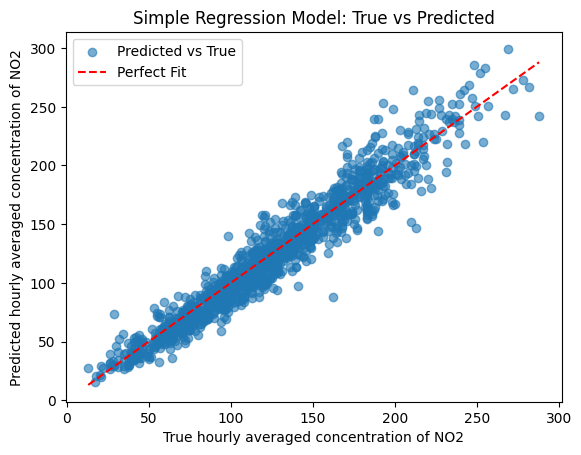

In [42]:
# Scatter plot: True vs Predicted
plt.scatter(y_valid, y_pred, alpha=0.6, label="Predicted vs True")
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--', label="Perfect Fit")
plt.title("Simple Regression Model: True vs Predicted")
plt.xlabel("True hourly averaged concentration of NO2")
plt.ylabel("Predicted hourly averaged concentration of NO2")
plt.legend()
plt.show()